In [278]:
# !pip install  pandas==1.1.2
# !pip install cvxpy==1.1
# !pip install PyPortfolioOpt==1.2.5 
# !pip install plotly==4.10.0

from pypfopt import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt import CLA

In [279]:
import plotly.express as px
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 20)
sns.set(rc={'figure.figsize':(12,8)})
%config InlineBackend.figure_format = 'retina'
print(pd.__version__)

1.1.2


In [280]:
fundamental = pd.read_csv('/content/drive/My Drive/data_analyst/Fundamental_ROIC_23.csv')
fundamental = fundamental[fundamental['Ticker'].isin(list(data_index.Ticker.unique()))]
fundamental_selected = fundamental.copy()[['Ticker', 'Quarter', 'Year', 'ROE', 'Invested_capital_t', 'FixedAssets', 'Current_assets', 'CurrentLiabilities', 'NOPAT_EBIT_1_tax' ]]
fundamental_selected['FixAssets_shift'] = fundamental_selected.groupby(['Ticker'])['FixedAssets'].shift(-1)
fundamental_selected['Current_assets_shift'] = fundamental_selected.groupby(['Ticker'])['Current_assets'].shift(-1)
fundamental_selected['CurrentLiabilities_shift'] = fundamental_selected.groupby(['Ticker'])['CurrentLiabilities'].shift(-1)
fundamental_selected['Invested_capital_last_quarter'] = fundamental_selected.apply(lambda row: row['FixAssets_shift'] + row['Current_assets_shift'] - row['CurrentLiabilities_shift'], axis=1)
fundamental_selected['ROIC_last_quarter'] =  fundamental_selected['NOPAT_EBIT_1_tax']/  fundamental_selected['Invested_capital_last_quarter']
fundamental_selected['YQ'] = fundamental_selected['Year'].apply(str) + "0"+ fundamental_selected['Quarter'].apply(str)
fundamental_selected['Quarter_delay'] = fundamental_selected.apply(lambda row: row['Year']*100+ row['Quarter']+1 if row['Quarter'] < 4 else (row['Year'] +1)*100+ 1, axis=1 )
#fundamental_selected['Quarter_delay'] = fundamental_selected.apply(lambda row: row['Year']*100+ row['Quarter']+2 if row['Quarter'] < 3 else (row['Year'] +1)*100+ 1 if row['Quarter']==3 else (row['Year'] +1)*100+ 2 , axis=1 )
#ROIC_final = fundamental_selected.copy().fillna(method='ffill')[['Ticker', 'Year', 'Quarter', 'ROIC_last_quarter', 'ROE' ]]
fundamental_selected = fundamental_selected.fillna(method='ffill')[['Ticker', 'YQ', 'ROE', 'ROIC_last_quarter', 'Quarter_delay' ]].reset_index(drop=True)

ROIC_final = fundamental_selected.copy()[['Ticker', 'Quarter_delay', 'ROE', 'ROIC_last_quarter']]
fundamental_selected[(fundamental_selected['Ticker'].isin(['MWG', 'VNM'])) & (fundamental_selected['YQ'].isin(['201903', '201904', '202001', '202002']))]


,Ticker,YQ,ROE,ROIC_last_quarter,Quarter_delay
12344,MWG,201903,0.075740,0.080248,201904
12574,VNM,201903,0.096628,0.098112,201904
12842,MWG,201904,0.070784,0.075067,202001
13076,VNM,201904,0.074047,0.073274,202001
13346,MWG,202001,0.084576,0.091299,202002
13578,VNM,202001,0.085742,0.092169,202002
13846,MWG,202002,0.062630,0.010114,202003
14077,VNM,202002,0.094936,0.010114,202003


In [281]:
import datetime as dt
start_date = '2012-01-03'
end_date = '2020-09-22'
#stock_list = tickers
#stock_list = [ 'VCB', 'CTD', 'BID', 'EIB', 'FPT']
#numstocks = len(stock_list)
data_index = pd.read_csv('/content/drive/My Drive/data_analyst/McapRank200_23.csv')
data_index = data_index[['Ticker', 'Date', 'Adj_Close', 'buckets', 'Year', 'Month', 'Quarter']] #
data_index['Quarter_delay'] = data_index.apply(lambda row: row['Year']*100+ row['Quarter'] , axis=1 )
data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index['Date_delay'] = data_index['Date'] + dt.timedelta(60)
data_index = data_index[ (data_index['Date'] >= start_date) & (data_index['Date'] <= end_date) ] 

data_index = pd.merge(data_index, ROIC_final, on=['Quarter_delay', 'Ticker'], how='left') #.dropna()
data_index['rank_main'] =   data_index.groupby('Date')['ROE'].rank(method='max', ascending=False)
#data_index['rank_pe'] =   data_index.groupby('Date')['PE_ratio'].rank(method='max', ascending=True)
data_index['rank_total'] =  - data_index['rank_main'] #+ test['rank_pe']
#data_index['ROIC_rank']= data_index.groupby('Date')['ROIC_last_quarter'].rank(pct=True) 
#data_index['ROIC_rank']= data_index.groupby('Date')['ROE'].rank(pct=True) 
data_index['rank_total_pct']= data_index.groupby('Date')['rank_total'].rank(pct=True, ascending=False) 


In [282]:

def filter_rank(x):
  if x >= 0.9:
    return "top1"
  elif x >= 0.8:
    return "top2"
  elif x >= 0.7:
    return "top3"
  elif x >= 0.6:
    return "top4"
  elif x >= 0.5:
    return "top5"
  elif x >= 0.4:
    return "top6"
  elif x >= 0.3:
    return "top7"
  elif x >= 0.2:
    return "top8"
  elif x >= 0.1:
    return "top9"  
  else:
    return "top10" 

data_index['uni9'] = data_index['rank_total_pct'].apply(filter_rank)
data_index_pivot = data_index.pivot(columns='Ticker', index='Date', values='uni9')
data_index_pivot_price = data_index.pivot(columns='Ticker', index='Date', values='Adj_Close')

In [283]:
first_date_quarter_df =  data_index.groupby(['Year', 'Quarter'])['Date'].apply(lambda x: x.min()).reset_index()
first_date_quarter = list(first_date_quarter_df.Date)

EOM  = data_index_pivot.copy()
EOM_price  = data_index_pivot_price.copy()
reb_date = first_date_quarter
#last reb là ngày cuối quý trước
if reb_date[-1] > pd.Timestamp.today():
  reb_date.pop()
weights_dfs = pd.DataFrame()
weights_RP_dfs = pd.DataFrame()
weights_dfs_m = pd.DataFrame()
for i in range(4,len(reb_date)):
    print(reb_date[i])
    uni_df = pd.DataFrame(EOM.loc[reb_date[i]].dropna().rename("uni9") ).reset_index() #Chọn ra mã từng thời kỳ
    
    top1 = list(uni_df[uni_df['uni9'] == "top1"].Ticker)
    EOM_top1 = EOM_price[ [c for c in EOM.columns if c in top1]]
    #df = EOM_top1.loc[:reb_date[i]].dropna(axis='columns', thresh=300).tail(100)    

    print('last row cum return==============')
    #if ((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0] >0.01:
      #print("--total return {}".format(((((df.pct_change() + 1).cumprod() -1).tail(1)).sum(axis=1)).iloc[0]))
    try:
      uni_df['count'] = uni_df.groupby('uni9')['Ticker'].transform('count')
      uni_df['weight'] = 1/uni_df['count'] 
      uni_df['uni_type'] = uni_df['uni9'] #.apply(lambda x: "top1" if x ==1 else "top2")
      uni_df['Date'] = reb_date[i]
      uni_final = uni_df[['Ticker', 'Date', 'weight', 'uni_type']]
      weights_dfs = weights_dfs.append(uni_final) 
      print(uni_final[uni_final['uni_type'] == 'top1'].head(10))
    except:
      print("Không đủ dữ liệu")
      pass    
    print("====================================================")

2013-01-02 00:00:00
last row cum return==============
    Ticker       Date    weight uni_type
5      ALP 2013-01-02  0.058824     top1
8      ASM 2013-01-02  0.058824     top1
62     HLG 2013-01-02  0.058824     top1
78     KAC 2013-01-02  0.058824     top1
79     KBC 2013-01-02  0.058824     top1
81     KDH 2013-01-02  0.058824     top1
86     LCG 2013-01-02  0.058824     top1
89     LSS 2013-01-02  0.058824     top1
103    NVT 2013-01-02  0.058824     top1
105    OGC 2013-01-02  0.058824     top1
2013-04-01 00:00:00
last row cum return==============
    Ticker       Date    weight uni_type
7      ALP 2013-04-01  0.058824     top1
22     BTS 2013-04-01  0.058824     top1
26     CHP 2013-04-01  0.058824     top1
66     HLG 2013-04-01  0.058824     top1
67     HOM 2013-04-01  0.058824     top1
81     KBC 2013-04-01  0.058824     top1
86     LCG 2013-04-01  0.058824     top1
117    POM 2013-04-01  0.058824     top1
128    PVL 2013-04-01  0.058824     top1
129    PVR 2013-04-01  0.058824

In [284]:
data_index_ROIC = data_index.copy()

weights_dfs['Quarter'] = weights_dfs['Date'].dt.quarter
weights_dfs['Year'] = weights_dfs['Date'].dt.year
weights_dfs['Uni'] = 1


data_index_ROIC = pd.merge(data_index_ROIC, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Quarter', 'Year'])
data_index_ROIC['uni_type']= data_index_ROIC['uni_type'].fillna(0)

# data_index_ROIC = pd.merge(data_index_ROIC, weights_dfs.loc[:, weights_dfs.columns != 'Date'], how='left', on=['Ticker', 'Quarter', 'Year'])
# data_index_ROIC['Uni']= data_index_ROIC['Uni'].fillna(0)


data_index_ROIC.to_csv("data_index_ROIC.csv")

In [285]:
a= data_index_ROIC.copy()
a= a[a['Date'] >= '2012-01-01' ] # & (a['Date'] <='2020-01-02')  2013-01-01 start_date
a['return'] = a.groupby('Ticker')['Adj_Close'].apply(lambda x: (x/x.shift(1)) - 1).copy()
portfolio = a.groupby(['uni_type', 'Date']).apply(lambda row: (row['return'] * row['weight']).sum()).rename('port_return')

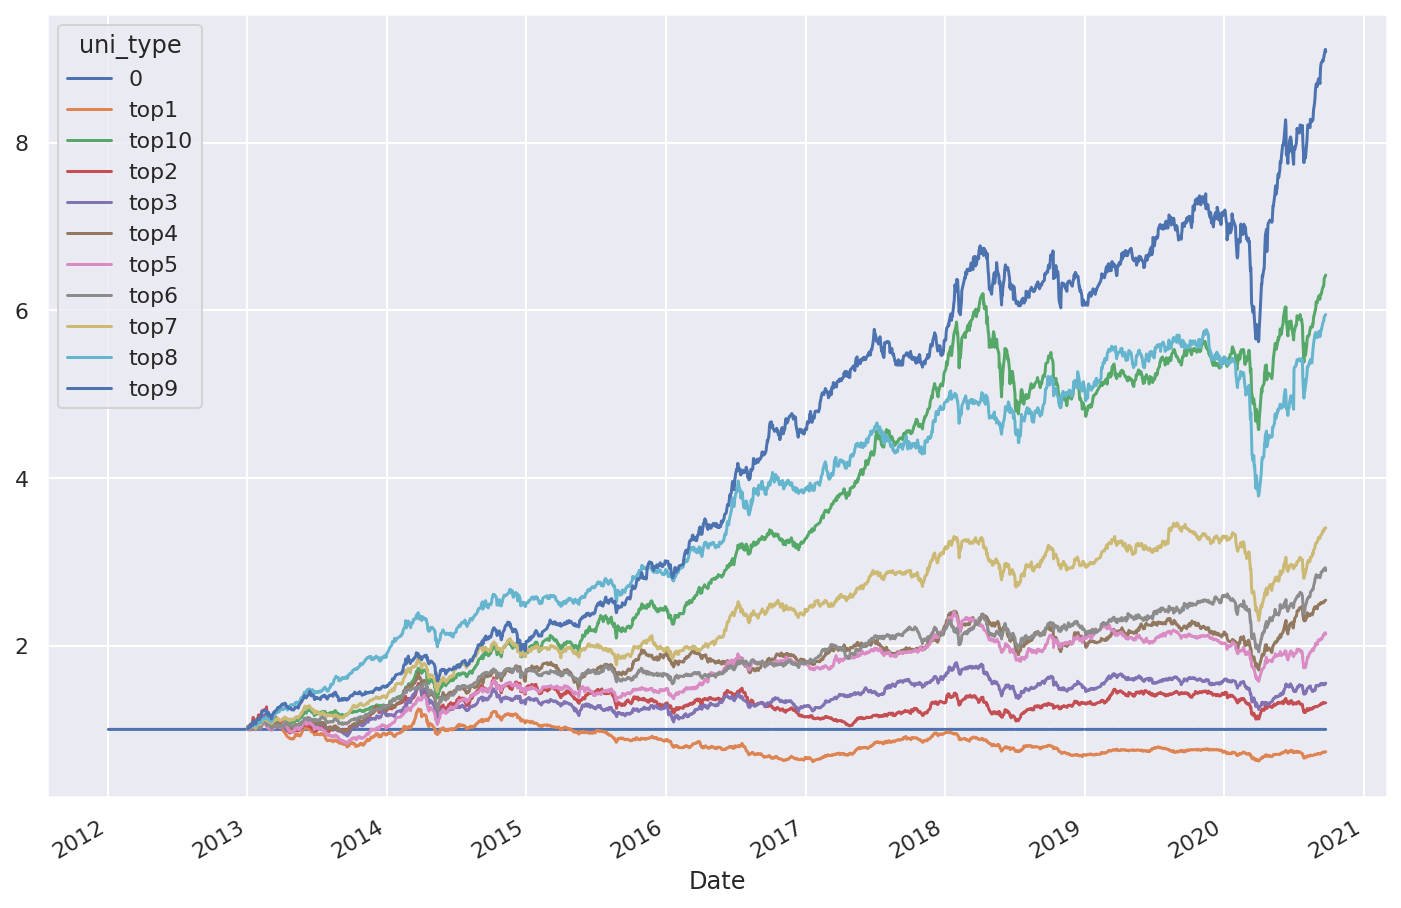

In [286]:
# vẽ đồ thị
portfolio3 = portfolio.reset_index()
portfolio3
#portfolio3[portfolio3['Date'] == '2020-04-23']
portfolio4 = portfolio3.pivot(index='Date', columns='uni_type', values='port_return')
((portfolio4 + 1).cumprod()).plot()

In [287]:
weights_dfs.to_csv("weightROE.csv")

In [288]:
#data_index = pd.read_csv('/content/drive/My Drive/data_analyst/McapRank200_23.csv')
#data_index['Date'] = pd.to_datetime(data_index['Date'], format='%Y-%m-%d')
data_index.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 435200 entries, 0 to 435199
Data columns (total 15 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Ticker             435200 non-null  object        
 1   Date               435200 non-null  datetime64[ns]
 2   Adj_Close          435200 non-null  float64       
 3   buckets            435200 non-null  int64         
 4   Year               435200 non-null  int64         
 5   Month              435200 non-null  int64         
 6   Quarter            435200 non-null  int64         
 7   Quarter_delay      435200 non-null  int64         
 8   Date_delay         435200 non-null  datetime64[ns]
 9   ROE                359375 non-null  float64       
 10  ROIC_last_quarter  359375 non-null  float64       
 11  rank_main          359375 non-null  float64       
 12  rank_total         359375 non-null  float64       
 13  rank_total_pct     359375 non-null  float64 

In [289]:
date_filter = (data_index['Date'] == '2012-01-31')
date_filter = (data_index['Date'] == '2020-09-22')
data_index.loc[date_filter].info()
data_index.loc[date_filter].dropna()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 435000 to 435199
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Ticker             200 non-null    object        
 1   Date               200 non-null    datetime64[ns]
 2   Adj_Close          200 non-null    float64       
 3   buckets            200 non-null    int64         
 4   Year               200 non-null    int64         
 5   Month              200 non-null    int64         
 6   Quarter            200 non-null    int64         
 7   Quarter_delay      200 non-null    int64         
 8   Date_delay         200 non-null    datetime64[ns]
 9   ROE                167 non-null    float64       
 10  ROIC_last_quarter  167 non-null    float64       
 11  rank_main          167 non-null    float64       
 12  rank_total         167 non-null    float64       
 13  rank_total_pct     167 non-null    float64       
 14  un

,Ticker,Date,Adj_Close,buckets,Year,Month,Quarter,Quarter_delay,Date_delay,ROE,ROIC_last_quarter,rank_main,rank_total,rank_total_pct,uni9
435000,VIC,2020-09-22,94600.0,1,2020,9,3,202003,2020-11-21,0.015086,0.010114,101.0,-101.0,0.604790,top4
435002,VHM,2020-09-22,76800.0,1,2020,9,3,202003,2020-11-21,0.049593,0.010114,39.0,-39.0,0.233533,top8
435003,VNM,2020-09-22,129600.0,1,2020,9,3,202003,2020-11-21,0.094936,0.010114,10.0,-10.0,0.059880,top10
435005,GAS,2020-09-22,71900.0,1,2020,9,3,202003,2020-11-21,0.032027,0.010114,71.0,-71.0,0.425150,top6
435006,ACV,2020-09-22,62200.0,1,2020,9,3,202003,2020-11-21,-0.009534,0.010114,158.0,-158.0,0.946108,top1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
435194,CRE,2020-09-22,24300.0,5,2020,9,3,202003,2020-11-21,0.044836,0.010114,47.0,-47.0,0.281437,top8
435196,NHH,2020-09-22,56000.0,5,2020,9,3,202003,2020-11-21,0.022037,0.010114,88.0,-88.0,0.526946,top5
435197,DNW,2020-09-22,19200.0,5,2020,9,3,202003,2020-11-21,0.037260,0.010114,58.0,-58.0,0.347305,top7
435198,KSV,2020-09-22,9500.0,5,2020,9,3,202003,2020-11-21,0.009070,0.010114,111.0,-111.0,0.664671,top4


In [290]:
pd.set_option('display.max_rows', 30)
last_date_quarter = data_index.groupby(['Year', 'Month'])['Date'].max()
list(last_date_quarter)
date_quarter_filter = (data_index['Date'].isin(list(last_date_quarter)))
data_index.loc[date_quarter_filter].groupby('Date').count()

,Ticker,Adj_Close,buckets,Year,Month,Quarter,Quarter_delay,Date_delay,ROE,ROIC_last_quarter,rank_main,rank_total,rank_total_pct,uni9
Date,,,,,,,,,,,,,,
2012-01-31,200,200,200,200,200,200,200,200,0,0,0,0,0,200
2012-02-29,200,200,200,200,200,200,200,200,0,0,0,0,0,200
2012-03-30,200,200,200,200,200,200,200,200,0,0,0,0,0,200
2012-04-27,200,200,200,200,200,200,200,200,166,166,166,166,166,200
2012-05-31,200,200,200,200,200,200,200,200,169,169,169,169,169,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-29,200,200,200,200,200,200,200,200,169,169,169,169,169,200
2020-06-30,200,200,200,200,200,200,200,200,168,168,168,168,168,200
2020-07-31,200,200,200,200,200,200,200,200,168,168,168,168,168,200


In [291]:
ROIC_final.info()
list(data_index.Ticker.unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14096 entries, 0 to 14095
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ticker             14096 non-null  object 
 1   Quarter_delay      14096 non-null  int64  
 2   ROE                14096 non-null  float64
 3   ROIC_last_quarter  14096 non-null  float64
dtypes: float64(2), int64(1), object(1)
memory usage: 440.6+ KB


['MSN',
 'BVH',
 'VCB',
 'CTG',
 'EIB',
 'VNM',
 'STB',
 'SQC',
 'VIC',
 'ACB',
 'HAG',
 'PVD',
 'DPM',
 'MBB',
 'VCG',
 'KBC',
 'PVX',
 'NVB',
 'OGC',
 'PVI',
 'SSI',
 'FPT',
 'PVS',
 'SJS',
 'ITA',
 'SHB',
 'VCF',
 'QCG',
 'KLS',
 'REE',
 'DHG',
 'IJC',
 'POM',
 'VSH',
 'PDR',
 'PPC',
 'OCH',
 'AGR',
 'KDC',
 'SBT',
 'DPR',
 'CII',
 'BCI',
 'GMD',
 'DIG',
 'DTL',
 'TIS',
 'PHR',
 'SGT',
 'BVS',
 'PNJ',
 'LSS',
 'SPM',
 'DLG',
 'VOS',
 'TRC',
 'ALP',
 'HPG',
 'PVT',
 'CTD',
 'KTB',
 'HBS',
 'NTL',
 'PVR',
 'MKP',
 'VNR',
 'ELC',
 'IDI',
 'ASM',
 'HLG',
 'HRC',
 'ITC',
 'NT2',
 'BSI',
 'SBS',
 'HT1',
 'PTL',
 'MPC',
 'VND',
 'RIC',
 'MCG',
 'PGD',
 'HVG',
 'SDI',
 'NTP',
 'TTP',
 'HCM',
 'AGD',
 'BTS',
 'LCG',
 'BMP',
 'TBC',
 'BMI',
 'CMG',
 'CHP',
 'NBB',
 'PXL',
 'LCM',
 'FDC',
 'SSC',
 'TDC',
 'KDH',
 'PET',
 'VIS',
 'SCR',
 'PGS',
 'SAM',
 'VHF',
 'TMP',
 'BIC',
 'VHC',
 'BHS',
 'DBC',
 'VST',
 'JVC',
 'CCL',
 'TMS',
 'PVC',
 'KAC',
 'TH1',
 'GTT',
 'BCC',
 'PGI',
 'NHW',
 'CTS',


In [292]:
date_filter = (data_index['Date'] == '2020-06-30')
data_index.loc[date_filter]
#data_index_pivot = data_index.copy().pivot(columns='Ticker', index='Date', values='uni9')

,Ticker,Date,Adj_Close,buckets,Year,Month,Quarter,Quarter_delay,Date_delay,ROE,ROIC_last_quarter,rank_main,rank_total,rank_total_pct,uni9
423200,VIC,2020-06-30,89000.0,1,2020,6,2,202002,2020-08-29,0.003590,0.039464,119.0,-119.0,0.708333,top3
423201,VCB,2020-06-30,80300.0,1,2020,6,2,202002,2020-08-29,NaN,NaN,NaN,NaN,NaN,top10
423202,VHM,2020-06-30,75500.0,1,2020,6,2,202002,2020-08-29,0.094608,0.413664,7.0,-7.0,0.041667,top10
423203,VNM,2020-06-30,112700.0,1,2020,6,2,202002,2020-08-29,0.085742,0.092169,10.0,-10.0,0.059524,top10
423204,BID,2020-06-30,37900.0,1,2020,6,2,202002,2020-08-29,NaN,NaN,NaN,NaN,NaN,top10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
423395,IPA,2020-06-30,19500.0,5,2020,6,2,202002,2020-08-29,0.001748,0.015402,129.0,-129.0,0.767857,top3
423396,EVF,2020-06-30,6400.0,5,2020,6,2,202002,2020-08-29,NaN,NaN,NaN,NaN,NaN,top10
423397,DNP,2020-06-30,16900.0,5,2020,6,2,202002,2020-08-29,0.001253,0.017687,133.0,-133.0,0.791667,top3
423398,ROS,2020-06-30,2970.0,5,2020,6,2,202002,2020-08-29,0.000068,0.006127,141.0,-141.0,0.839286,top2
